In [5]:
from sklearn.datasets import make_moons, make_blobs
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
datasize = 1000

Xs, ys = make_blobs(datasize, centers=[[0, 0], [0, 2]], cluster_std=[0.3,0.35])
Xt, yt = make_blobs(datasize, centers=[[2, -2], [2, 0.2]], cluster_std=[0.35,0.4])

Text(0.5, 1.0, 'Source domain and target domain blobs data')

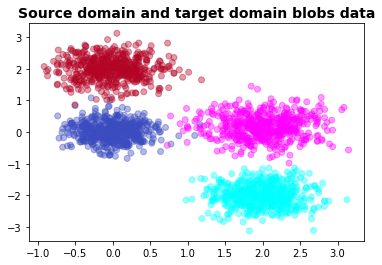

In [30]:
plt.scatter(Xs[:,0], Xs[:,1], c=ys, cmap='coolwarm', alpha=0.4)
pos_idx_src = np.where = 
plt.scatter()
plt.scatter(Xt[:,0], Xt[:,1], c=yt, cmap='cool', alpha=0.4)
colors = ["c", "m"]
x_all = [Xs, Xt]
y_all = [ys, yt]
labels = ["source", "Target"]
for i in range(2):
    
    idx_pos = np.where(y_all[i] == 1)
    idx_neg = np.where(y_all[i] == 0)
    plt.scatter(x_all[i][idx_pos, 0], x_all[i][idx_pos, 1]

plt.title('Source domain and target domain blobs data',fontsize=14,fontweight='bold')

In [59]:
ys

array([0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0,

In [36]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score
# from kale.pipeline.multi_domain_adapter import _CoDeRLS

In [37]:
clf = RidgeClassifier(alpha=1.0)
clf.fit(Xs, ys)

ys_score = clf.decision_function(Xs)
yt_score = clf.decision_function(Xt)
yt_pred = clf.predict(Xt)
print('Accuracy on target domain: {:.2f}'.format(accuracy_score(yt, yt_pred)))

Accuracy on target domain: 0.51


In [38]:
import seaborn as sns

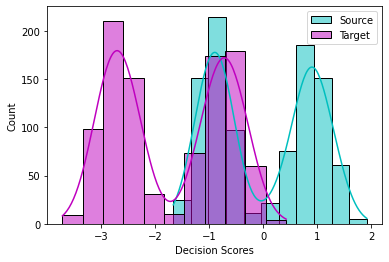

In [58]:
sns.histplot(ys_score, color="c", label="Source", kde=True)
sns.histplot(yt_score, color="m", label="Target", kde=True)
# plt.hist(ys_score, color="c", label="Source", histtype="step")
# plt.hist(yt_score, color="orange", label="Target", histtype="step")
plt.xlabel("Decision Scores")
plt.legend()

In [ ]:
covariates = np.zeros(N * 2)
covariates[:N] = 1
enc = OneHotEncoder(handle_unknown='ignore')
covariates_mat = enc.fit_transform(covariates.reshape(-1, 1)).toarray()